# Personas in Space

In post 020, we tracked persona drift in text-only conversations. But what happens when agents exist in a **2D spatial world**? Does spatial context affect persona stability?

This post combines:
- **2D world simulation** (from post 017): Agents move and interact spatially
- **Persona drift tracking** (from post 020): ConvoKit metrics over time
- **30 iterations**: Enough to see drift patterns
- **2 and 4 speakers**: Compare small vs medium groups

## The Question

Does spatial context make personas more or less stable? Does proximity affect how agents communicate? Do agents develop spatial behaviors that influence their personas?


## Setup and Imports


In [ ]:
import re
from typing import List, Dict
from collections import defaultdict
from dataclasses import dataclass, field
from dotenv import load_dotenv
from openai import OpenAI
from tqdm import tqdm
from random import random, randint, shuffle
import numpy as np
import matplotlib.pyplot as plt

# ConvoKit imports
from convokit import Corpus, Utterance, Speaker
from convokit.text_processing import TextParser
from convokit import PolitenessStrategies

load_dotenv("../../.env")
client = OpenAI()

GRID_SIZE = 20


## 2D World Agent Class

We'll use the Agent class from post 017 that supports spatial movement.


In [13]:
@dataclass
class Agent:
    name: str
    x: int
    y: int
    color: str
    history: list = field(default_factory=list)
    
    def move(self, dx, dy):
        self.x = max(0, min(GRID_SIZE-1, self.x + dx))
        self.y = max(0, min(GRID_SIZE-1, self.y + dy))
    
    def get_position(self):
        return (self.x, self.y)
    
    def distance_to(self, other):
        """Calculate Euclidean distance to another agent."""
        return np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)


## 2D World Conversation Runner

This combines spatial movement with conversation, tracking both over 30 iterations.


In [38]:
def run_2d_world_conversation(
    iterations: int,
    participant_count: int,
    evaluation_interval: int = 5,
) -> tuple[List[Dict], List[Dict], List[Dict]]:
    """
    Run conversation in 2D world with spatial movement.
    Returns (conversation_history, metric_history, position_history)
    """
    conversation_history = []
    metric_history = []
    position_history = []
    
    # Initialize agents in 2D space
    agents = []
    for i in range(participant_count):
        # Spread agents across the grid
        x = randint(0, GRID_SIZE - 1)
        y = randint(0, GRID_SIZE - 1)
        agents.append(Agent(f"speaker_{i+1}", x, y, f"color_{i+1}"))
    
    identity_summaries = {}
    
    # Bootstrap identities
    for agent in agents:
        bootstrap_messages = [
            {
                "role": "system",
                "content": (
                    f"You are {agent.name} in a group conversation among "
                    "other people's avatars in a 2D virtual world. "
                    "You can move around and interact with others. "
                    "Imagine your own background, priorities, and communication "
                    "style. First, in 2-3 sentences, describe who you are and "
                    "what you care about."
                ),
            },
        ]
        
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=bootstrap_messages,
            store=False,
        )
        first_message = response.choices[0].message.content
        identity_summaries[agent.name] = first_message
        conversation_history.append(
            {"role": "assistant", "name": agent.name, "content": first_message}
        )
    
    # Record initial positions
    position_history.append({
        agent.name: (agent.x, agent.y) for agent in agents
    })
    
    def get_agent_action(agent: Agent, all_agents: List[Agent], transcript: List[str]):
        """Get action for an agent in the 2D world."""
        others = [a for a in all_agents if a != agent]
        others_loc = "\\n".join([f"- {a.name}: ({a.x}, {a.y})" for a in others])
        
        # Calculate distances
        nearby = [a for a in others if agent.distance_to(a) <= 5]
        nearby_info = "\\n".join([f"- {a.name}: ({a.x}, {a.y}), distance {agent.distance_to(a):.1f}" for a in nearby])
        if not nearby_info:
            nearby_info = "None (you are alone)"
        
        system_prompt = f"""
You have just joined an online multiplayer chatroom as an avatar in a 2D grid. Discuss any topic, including those beyond the grid.

You are {agent.name}, positioned at ({agent.x}, {agent.y}) in a 20x20 grid.

Other avatars currently visible:
{others_loc}

Nearby avatars (within 5 units):
{nearby_info}

Recent chat messages:
{chr(10).join(transcript[-3:]) if transcript else "No messages yet."}

You can do BOTH:
1. Move your avatar using [MOVE: DIRECTION] (UP, DOWN, LEFT, RIGHT)
2. Chat about anything - the grid, your position, or any topic you want

You can move and speak in the same turn. Format: [MOVE: DIRECTION] followed by your message, or just speak without moving.

Keep your response short (1-2 sentences).
"""
        
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "system", "content": system_prompt}]
        )
        content = response.choices[0].message.content.strip()
        
        # Parse movement
        direction = None
        match = re.search(r'\[MOVE:\s*(\w+)\]', content)
        if match:
            direction = match.group(1).upper()
            if direction == "UP": agent.move(0, 1)
            elif direction == "DOWN": agent.move(0, -1)
            elif direction == "LEFT": agent.move(-1, 0)
            elif direction == "RIGHT": agent.move(1, 0)
        
        # Extract message
        message = re.sub(r'\[MOVE:\s*\w+\]', '', content).strip()
        if message:
            transcript.append(f"{agent.name}: {message}")
            conversation_history.append(
                {"role": "assistant", "name": agent.name, "content": message}
            )
    
    # Run iterations
    transcript = []
    for i in tqdm(range(iterations), desc=f"Running {participant_count}-speaker 2D conversation"):
        # Shuffle agent order each round
        shuffled_agents = agents.copy()
        shuffle(shuffled_agents)
        
        # Each agent acts
        for agent in shuffled_agents:
            if random() < 0.7:  # 70% chance to act
                get_agent_action(agent, agents, transcript)
        
        # Record positions
        position_history.append({
            agent.name: (agent.x, agent.y) for agent in agents
        })
        
        # Evaluate metrics at intervals
        if (i + 1) % evaluation_interval == 0:
            # Evaluate using the function defined below
            corpus = conversation_to_corpus(conversation_history)
            metrics = {
                "dynamic": compute_dynamic_score(corpus),
                "conclusiveness": compute_conclusiveness_score(corpus),
                "speaker_identity": compute_speaker_identity_score(corpus),
                "speaker_fluidity": compute_speaker_fluidity_score(corpus),
                "round": i + 1
            }
            metric_history.append(metrics)
    
    return conversation_history, metric_history, position_history


In [39]:
def conversation_to_corpus(conversation_history: List[Dict]) -> Corpus:
    """Convert conversation history to a ConvoKit Corpus."""
    utterances = []
    
    for idx, msg in enumerate(conversation_history):
        if msg.get("role") == "assistant" and "name" in msg:
            speaker_id = msg["name"]
            text = msg["content"]
            
            utterance = Utterance(
                id=f"utt_{idx}",
                speaker=Speaker(id=speaker_id),
                text=text
            )
            utterance.meta["timestamp"] = idx
            utterances.append(utterance)
    
    return Corpus(utterances=utterances)

def compute_dynamic_score(corpus: Corpus) -> float:
    """Dynamic: Collaborative (1) vs. Competitive (10)"""
    try:
        parser = TextParser()
        text_corpus = parser.transform(corpus)
        ps = PolitenessStrategies()
        ps_corpus = ps.transform(text_corpus)
        
        politeness_scores = []
        for utt in ps_corpus.iter_utterances():
            ps_score = utt.meta.get("politeness_strategies", {})
            positive_markers = sum([
                ps_score.get("feature_politeness_==HASPOSITIVE==", 0),
                ps_score.get("feature_politeness_==HASNEGATIVE==", 0) * -1,
            ])
            politeness_scores.append(positive_markers)
        
        avg_politeness = np.mean(politeness_scores) if politeness_scores else 0
        avg_politeness_normalized = min(1.0, max(0.0, avg_politeness / 5.0))
        
        speaker_counts = defaultdict(int)
        for utt in corpus.iter_utterances():
            speaker_counts[utt.speaker.id] += 1
        
        if len(speaker_counts) == 0:
            return 5.0
        
        total = sum(speaker_counts.values())
        probs = [count / total for count in speaker_counts.values()]
        entropy = -sum(p * np.log2(p) for p in probs if p > 0)
        max_entropy = np.log2(len(speaker_counts))
        balance_score = entropy / max_entropy if max_entropy > 0 else 0
        
        combined = (avg_politeness_normalized + balance_score) / 2
        score = 10 - (combined * 9)
        return max(1, min(10, score))
    except Exception as e:
        print(f"Error computing dynamic score: {e}")
        return 5.0

def compute_conclusiveness_score(corpus: Corpus) -> float:
    """Conclusiveness: Consensus (1) vs. Divergence (10)"""
    try:
        # Check if corpus is valid
        if corpus is None:
            return 5.0
        
        # Get utterances directly without Coordination transformer (more reliable)
        try:
            utterances = list(corpus.iter_utterances())
        except (AttributeError, TypeError):
            return 5.0
        
        if len(utterances) == 0:
            return 5.0
        
        # Expanded agreement markers (using word boundaries to avoid false positives)
        # Strong agreement markers
        strong_agreement_patterns = [
            r'\bagree\b', r'\bagreed\b', r'\bagreeing\b', r'\bagreement\b',
            r'\bexactly\b', r'\babsolutely\b', r'\bdefinitely\b', r'\bcertainly\b',
            r'\bindeed\b', r'\bprecisely\b', r'\bcorrect\b', r'\bright\b',
            r'\btrue\b', r'\bthat\'?s right\b', r'\bthat\'?s correct\b',
            r'\bi agree\b', r'\bwe agree\b', r'\bi completely agree\b',
            r'\bexactly right\b', r'\bspot on\b', r'\bwell said\b',
            r'\bperfect\b', r'\bexcellent point\b', r'\bthat\'?s exactly\b',
            r'\babsolutely right\b', r'\bdefinitely right\b', r'\bcompletely agree\b',
            r'\bwholeheartedly\b', r'\bunquestionably\b', r'\bwithout doubt\b'
        ]
        
        # Moderate agreement markers
        moderate_agreement_patterns = [
            r'\byes\b', r'\byeah\b', r'\byep\b', r'\byup\b', r'\bsure\b', r'\bokay\b', r'\bok\b',
            r'\bthat makes sense\b', r'\bthat\'?s a good point\b', r'\bgood point\b',
            r'\bi see\b', r'\bi understand\b', r'\bi get it\b', r'\bi follow\b',
            r'\bthat\'?s fair\b', r'\bfair enough\b', r'\bthat\'?s reasonable\b',
            r'\bi think so\b', r'\bi believe so\b', r'\bprobably\b', r'\blikely\b',
            r'\bsimilar\b', r'\bsimilarly\b', r'\blikewise\b', r'\bsame here\b',
            r'\bme too\b', r'\bsame\b', r'\bconcur\b', r'\bconcurring\b',
            r'\bvalid\b', r'\bvalid point\b', r'\bsound\b', r'\bsound point\b',
            r'\bhelpful\b', r'\buseful\b', r'\binsightful\b', r'\binteresting\b',
            r'\bthat\'?s interesting\b', r'\bgood idea\b', r'\bgood thinking\b'
        ]
        
        # Strong disagreement markers
        strong_disagreement_patterns = [
            r'\bdisagree\b', r'\bdisagreed\b', r'\bdisagreeing\b', r'\bdisagreement\b',
            r'\bdispute\b', r'\bdisputing\b', r'\bdiffer\b', r'\bdiffered\b', r'\bdiffering\b',
            r'\bwrong\b', r'\bincorrect\b', r'\bnot correct\b', r'\bnot right\b',
            r'\bnot true\b', r'\bthat\'?s wrong\b', r'\bthat\'?s incorrect\b',
            r'\bi disagree\b', r'\bwe disagree\b', r'\bi strongly disagree\b',
            r'\bdon\'?t agree\b', r'\bdoesn\'?t agree\b', r'\bdidn\'?t agree\b',
            r'\bcan\'?t agree\b', r'\bcannot agree\b', r'\bwon\'?t agree\b',
            r'\bobject\b', r'\bobjection\b', r'\bchallenge\b', r'\bchallenging\b',
            r'\bcontradict\b', r'\bcontradicting\b', r'\bcontradiction\b',
            r'\bfalse\b', r'\buntrue\b', r'\bmistaken\b', r'\berror\b',
            r'\bflawed\b', r'\bproblematic\b', r'\bunacceptable\b', r'\bunreasonable\b',
            r'\babsurd\b', r'\bridiculous\b', r'\boutrageous\b', r'\bunfounded\b'
        ]
        
        # Moderate disagreement markers (more context-dependent)
        moderate_disagreement_patterns = [
            r'\bhowever\b', r'\balthough\b', r'\bbut\b', r'\bthough\b', r'\bwhereas\b',
            r'\bnot necessarily\b', r'\bnot quite\b', r'\bnot exactly\b', r'\bnot really\b',
            r'\bnot entirely\b', r'\bnot completely\b', r'\bnot fully\b',
            r'\bpartially\b', r'\bpartly\b', r'\bsomewhat\b', r'\bto some extent\b',
            r'\bcontrary\b', r'\bconversely\b', r'\bon the other hand\b',
            r'\bcontrast\b', r'\bcontrasting\b', r'\bunlike\b', r'\bdifferent\b',
            r'\bdifferently\b', r'\balternative\b', r'\balternatively\b',
            r'\bactually\b', r'\bin fact\b', r'\bin reality\b', r'\bthe reality is\b',
            r'\bwell\b', r'\bwait\b', r'\bhold on\b', r'\bnot so fast\b',
            r'\bnot sure\b', r'\bnot certain\b', r'\buncertain\b', r'\bdoubtful\b',
            r'\bquestionable\b', r'\bdebatable\b', r'\barguable\b', r'\bmaybe not\b',
            r'\bperhaps not\b', r'\bpossibly not\b', r'\bnot convinced\b',
            r'\bskeptical\b', r'\bskepticism\b', r'\bconcern\b', r'\bconcerned\b',
            r'\bissue\b', r'\bproblem\b', r'\bproblems\b', r'\bconcern\b',
            r'\bworry\b', r'\bworried\b', r'\bhesitant\b', r'\bhesitation\b',
            r'\bdispute\b', r'\bquestion\b', r'\bquestions\b', r'\bchallenge\b',
            r'\bdisagree with\b', r'\bdiffer from\b', r'\bcontrary to\b',
            r'\bin contrast\b', r'\bby contrast\b', r'\bunlike\b', r'\bversus\b',
            r'\bvs\b', r'\bcompared to\b', r'\bcompared with\b'
        ]
        
        # Count markers with word boundary matching
        strong_agreement_count = 0
        moderate_agreement_count = 0
        strong_disagreement_count = 0
        moderate_disagreement_count = 0
        
        for utt in utterances:
            # Safely get text
            try:
                if not hasattr(utt, 'text') or not utt.text:
                    continue
                text_lower = str(utt.text).lower()
            except (AttributeError, TypeError):
                continue
            
            # Count strong agreement (once per utterance)
            found_strong_agree = False
            for pattern in strong_agreement_patterns:
                try:
                    if re.search(pattern, text_lower):
                        strong_agreement_count += 1
                        found_strong_agree = True
                        break
                except Exception:
                    continue
            
            # Count moderate agreement (only if no strong agreement found)
            if not found_strong_agree:
                for pattern in moderate_agreement_patterns:
                    try:
                        if re.search(pattern, text_lower):
                            moderate_agreement_count += 1
                            break
                    except Exception:
                        continue
            
            # Count strong disagreement (once per utterance)
            found_strong_disagree = False
            for pattern in strong_disagreement_patterns:
                try:
                    if re.search(pattern, text_lower):
                        strong_disagreement_count += 1
                        found_strong_disagree = True
                        break
                except Exception:
                    continue
            
            # Count moderate disagreement (only if no strong disagreement found)
            if not found_strong_disagree:
                for pattern in moderate_disagreement_patterns:
                    try:
                        if re.search(pattern, text_lower):
                            moderate_disagreement_count += 1
                            break
                    except Exception:
                        continue
        
        # Weighted counts (strong markers count more)
        total_agreement = strong_agreement_count * 2 + moderate_agreement_count
        total_disagreement = strong_disagreement_count * 2 + moderate_disagreement_count
        
        # Handle edge cases
        if total_agreement == 0 and total_disagreement == 0:
            return 5.0
        elif total_disagreement == 0:
            return 1.0
        elif total_agreement == 0:
            return 10.0
        
        # Calculate ratio and score using logarithmic scaling
        agreement_ratio = total_agreement / total_disagreement
        
        # Map ratio to 1-10 scale using logarithmic scaling for smoother transitions
        import math
        
        if agreement_ratio > 0:
            log_ratio = math.log(agreement_ratio)
            
            # Map log_ratio from [-2.3, 2.3] to [10, 1]
            # When log_ratio = 0 (ratio = 1.0), score = 5.0
            if log_ratio >= 0:
                # Consensus range: log_ratio [0, 2.3] -> score [5.0, 1.0]
                score = 5.0 - (log_ratio / 2.3) * 4.0
            else:
                # Divergence range: log_ratio [-2.3, 0] -> score [10.0, 5.0]
                score = 5.0 - (log_ratio / 2.3) * 5.0
        else:
            score = 10.0
        
        score = max(1.0, min(10.0, score))
        return score
    except Exception as e:
        print(f"Error computing conclusiveness score: {e}")
        return 5.0

def compute_speaker_identity_score(corpus: Corpus) -> float:
    """Speaker Identity: Similarity (1) vs. Diversity (10)"""
    # #region agent log
    import json; open('/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.cursor/debug.log', 'a').write(json.dumps({"sessionId":"debug-session","runId":"run1","hypothesisId":"B","location":"compute_speaker_identity_score:entry","message":"Function entry","data":{"corpus_size":len(list(corpus.iter_utterances())) if corpus else 0},"timestamp":int(__import__('time').time()*1000)})+'\n')
    # #endregion
    try:
        speakers = {}
        
        for utt in corpus.iter_utterances():
            speaker_id = utt.speaker.id
            if speaker_id not in speakers:
                speakers[speaker_id] = {"words": set()}
            
            words = set(re.findall(r'\b\w+\b', utt.text.lower()))
            speakers[speaker_id]["words"].update(words)
        
        # #region agent log
        import json; open('/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.cursor/debug.log', 'a').write(json.dumps({"sessionId":"debug-session","runId":"run1","hypothesisId":"B","location":"compute_speaker_identity_score:after_collect","message":"After collecting words","data":{"num_speakers":len(speakers),"speaker_word_counts":{k:len(v["words"]) for k,v in speakers.items()}},"timestamp":int(__import__('time').time()*1000)})+'\n')
        # #endregion
        
        if len(speakers) < 2:
            # #region agent log
            import json; open('/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.cursor/debug.log', 'a').write(json.dumps({"sessionId":"debug-session","runId":"run1","hypothesisId":"B","location":"compute_speaker_identity_score:early_return","message":"Early return: <2 speakers","data":{"num_speakers":len(speakers)},"timestamp":int(__import__('time').time()*1000)})+'\n')
            # #endregion
            return 5.0
        
        speaker_list = list(speakers.keys())
        overlaps = []
        
        for i in range(len(speaker_list)):
            for j in range(i + 1, len(speaker_list)):
                words_i = speakers[speaker_list[i]]["words"]
                words_j = speakers[speaker_list[j]]["words"]
                
                if len(words_i) == 0 or len(words_j) == 0:
                    continue
                
                overlap = len(words_i & words_j) / len(words_i | words_j)
                overlaps.append(overlap)
        
        # #region agent log
        import json; open('/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.cursor/debug.log', 'a').write(json.dumps({"sessionId":"debug-session","runId":"run1","hypothesisId":"B","location":"compute_speaker_identity_score:overlaps_check","message":"Checking overlaps","data":{"num_overlaps":len(overlaps),"overlaps":overlaps[:5] if overlaps else []},"timestamp":int(__import__('time').time()*1000)})+'\n')
        # #endregion
        
        if not overlaps:
            # #region agent log
            import json; open('/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.cursor/debug.log', 'a').write(json.dumps({"sessionId":"debug-session","runId":"run1","hypothesisId":"B","location":"compute_speaker_identity_score:empty_overlaps","message":"Empty overlaps, returning 5.0","data":{},"timestamp":int(__import__('time').time()*1000)})+'\n')
            # #endregion
            return 5.0
        
        avg_overlap = np.mean(overlaps)
        score = 10 - (avg_overlap * 9)
        result = max(1, min(10, score))
        # #region agent log
        import json; open('/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.cursor/debug.log', 'a').write(json.dumps({"sessionId":"debug-session","runId":"run1","hypothesisId":"B","location":"compute_speaker_identity_score:return","message":"Function return","data":{"avg_overlap":avg_overlap,"score":result},"timestamp":int(__import__('time').time()*1000)})+'\n')
        # #endregion
        return result
    except Exception as e:
        # #region agent log
        import json; open('/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.cursor/debug.log', 'a').write(json.dumps({"sessionId":"debug-session","runId":"run1","hypothesisId":"C","location":"compute_speaker_identity_score:exception","message":"Exception caught","data":{"error":str(e)},"timestamp":int(__import__('time').time()*1000)})+'\n')
        # #endregion
        print(f"Error computing speaker identity score: {e}")
        return 5.0

def compute_speaker_fluidity_score(corpus: Corpus, window_size: int = 20) -> float:
    """Speaker Fluidity: Malleability (1) vs. Consistency (10)"""
    # #region agent log
    import json; open('/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.cursor/debug.log', 'a').write(json.dumps({"sessionId":"debug-session","runId":"run1","hypothesisId":"A","location":"compute_speaker_fluidity_score:entry","message":"Function entry","data":{"corpus_size":len(list(corpus.iter_utterances())) if corpus else 0},"timestamp":int(__import__('time').time()*1000)})+'\n')
    # #endregion
    try:
        speaker_utterances = defaultdict(list)
        
        for utt in corpus.iter_utterances():
            speaker_utterances[utt.speaker.id].append({
                "text": utt.text,
                "timestamp": utt.meta.get("timestamp", 0)
            })
        
        # #region agent log
        import json; open('/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.cursor/debug.log', 'a').write(json.dumps({"sessionId":"debug-session","runId":"run1","hypothesisId":"E","location":"compute_speaker_fluidity_score:after_collect","message":"After collecting utterances","data":{"num_speakers":len(speaker_utterances),"utterance_counts":{k:len(v) for k,v in speaker_utterances.items()}},"timestamp":int(__import__('time').time()*1000)})+'\n')
        # #endregion
        
        if len(speaker_utterances) == 0:
            # #region agent log
            import json; open('/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.cursor/debug.log', 'a').write(json.dumps({"sessionId":"debug-session","runId":"run1","hypothesisId":"A","location":"compute_speaker_fluidity_score:early_return","message":"Early return: no speakers","data":{},"timestamp":int(__import__('time').time()*1000)})+'\n')
            # #endregion
            return 5.0
        
        # Use adaptive window size: at least 4 utterances (2 per half), or use the specified window_size
        # Find the minimum utterances any speaker has, and use that to set a reasonable threshold
        min_utterances = min(len(utts) for utts in speaker_utterances.values()) if speaker_utterances else 0
        # Use at least 4, but prefer the specified window_size if speakers have enough utterances
        adaptive_window = max(4, min(window_size, min_utterances)) if min_utterances >= 4 else 4
        
        consistency_scores = []
        
        for speaker_id, utts in speaker_utterances.items():
            # Require at least 4 utterances to split into two halves
            if len(utts) < 4:
                # #region agent log
                import json; open('/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.cursor/debug.log', 'a').write(json.dumps({"sessionId":"debug-session","runId":"run1","hypothesisId":"E","location":"compute_speaker_fluidity_score:skip_speaker","message":"Skipping speaker: <4 utterances","data":{"speaker_id":speaker_id,"num_utterances":len(utts)},"timestamp":int(__import__('time').time()*1000)})+'\n')
                # #endregion
                continue
            
            utts_sorted = sorted(utts, key=lambda x: x["timestamp"])
            mid_point = len(utts_sorted) // 2
            
            first_half_words = set()
            second_half_words = set()
            
            for utt in utts_sorted[:mid_point]:
                words = set(re.findall(r'\b\w+\b', utt["text"].lower()))
                first_half_words.update(words)
            
            for utt in utts_sorted[mid_point:]:
                words = set(re.findall(r'\b\w+\b', utt["text"].lower()))
                second_half_words.update(words)
            
            if len(first_half_words) == 0 or len(second_half_words) == 0:
                # #region agent log
                import json; open('/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.cursor/debug.log', 'a').write(json.dumps({"sessionId":"debug-session","runId":"run1","hypothesisId":"E","location":"compute_speaker_fluidity_score:skip_empty","message":"Skipping: empty word sets","data":{"speaker_id":speaker_id,"first_half_size":len(first_half_words),"second_half_size":len(second_half_words)},"timestamp":int(__import__('time').time()*1000)})+'\n')
                # #endregion
                continue
            
            overlap = len(first_half_words & second_half_words)
            union = len(first_half_words | second_half_words)
            similarity = overlap / union if union > 0 else 0
            consistency_scores.append(similarity)
        
        # #region agent log
        import json; open('/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.cursor/debug.log', 'a').write(json.dumps({"sessionId":"debug-session","runId":"run1","hypothesisId":"E","location":"compute_speaker_fluidity_score:consistency_check","message":"Checking consistency scores","data":{"num_consistency_scores":len(consistency_scores),"consistency_scores":consistency_scores[:5] if consistency_scores else []},"timestamp":int(__import__('time').time()*1000)})+'\n')
        # #endregion
        
        if not consistency_scores:
            # #region agent log
            import json; open('/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.cursor/debug.log', 'a').write(json.dumps({"sessionId":"debug-session","runId":"run1","hypothesisId":"E","location":"compute_speaker_fluidity_score:empty_consistency","message":"Empty consistency scores, returning 5.0","data":{},"timestamp":int(__import__('time').time()*1000)})+'\n')
            # #endregion
            return 5.0
        
        avg_consistency = np.mean(consistency_scores)
        score = 1 + (avg_consistency * 9)
        result = max(1, min(10, score))
        # #region agent log
        import json; open('/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.cursor/debug.log', 'a').write(json.dumps({"sessionId":"debug-session","runId":"run1","hypothesisId":"E","location":"compute_speaker_fluidity_score:return","message":"Function return","data":{"avg_consistency":avg_consistency,"score":result},"timestamp":int(__import__('time').time()*1000)})+'\n')
        # #endregion
        return result
    except Exception as e:
        # #region agent log
        import json; open('/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.cursor/debug.log', 'a').write(json.dumps({"sessionId":"debug-session","runId":"run1","hypothesisId":"A","location":"compute_speaker_fluidity_score:exception","message":"Exception caught","data":{"error":str(e)},"timestamp":int(__import__('time').time()*1000)})+'\n')
        # #endregion
        print(f"Error computing speaker fluidity score: {e}")
        return 5.0

def evaluate_conversation(conversation_history: List[Dict]) -> Dict[str, float]:
    """Compute all 4 evaluation metrics using ConvoKit."""
    corpus = conversation_to_corpus(conversation_history)
    
    return {
        "dynamic": compute_dynamic_score(corpus),
        "conclusiveness": compute_conclusiveness_score(corpus),
        "speaker_identity": compute_speaker_identity_score(corpus),
        "speaker_fluidity": compute_speaker_fluidity_score(corpus)
    }


In [40]:
# Run 2-speaker conversation in 2D world
print("Running 2-speaker conversation in 2D world...")
conv_2d_2speaker, metrics_2d_2speaker, positions_2d_2speaker = run_2d_world_conversation(
    iterations=30,
    participant_count=2,
    evaluation_interval=5
)

print("\\n=== 2-Speaker 2D World Results ===")
for metric_point in metrics_2d_2speaker:
    round_num = metric_point["round"]
    print(f"\\nRound {round_num}:")
    print(f"  Dynamic: {metric_point['dynamic']:.2f}/10")
    print(f"  Conclusiveness: {metric_point['conclusiveness']:.2f}/10")
    print(f"  Speaker Identity: {metric_point['speaker_identity']:.2f}/10")
    print(f"  Speaker Fluidity: {metric_point['speaker_fluidity']:.2f}/10")

# Run 4-speaker conversation in 2D world
print("\\n\\nRunning 4-speaker conversation in 2D world...")
conv_2d_4speaker, metrics_2d_4speaker, positions_2d_4speaker = run_2d_world_conversation(
    iterations=30,
    participant_count=4,
    evaluation_interval=5
)

print("\\n=== 4-Speaker 2D World Results ===")
for metric_point in metrics_2d_4speaker:
    round_num = metric_point["round"]
    print(f"\\nRound {round_num}:")
    print(f"  Dynamic: {metric_point['dynamic']:.2f}/10")
    print(f"  Conclusiveness: {metric_point['conclusiveness']:.2f}/10")
    print(f"  Speaker Identity: {metric_point['speaker_identity']:.2f}/10")
    print(f"  Speaker Fluidity: {metric_point['speaker_fluidity']:.2f}/10")


Running 2-speaker conversation in 2D world...


Running 2-speaker 2D conversation: 100%|██████████| 30/30 [00:47<00:00,  1.59s/it]


\n=== 2-Speaker 2D World Results ===
\nRound 5:
  Dynamic: 4.94/10
  Conclusiveness: 5.00/10
  Speaker Identity: 8.11/10
  Speaker Fluidity: 2.34/10
\nRound 10:
  Dynamic: 5.07/10
  Conclusiveness: 5.40/10
  Speaker Identity: 7.91/10
  Speaker Fluidity: 2.34/10
\nRound 15:
  Dynamic: 4.96/10
  Conclusiveness: 5.00/10
  Speaker Identity: 7.93/10
  Speaker Fluidity: 2.31/10
\nRound 20:
  Dynamic: 4.94/10
  Conclusiveness: 4.11/10
  Speaker Identity: 7.45/10
  Speaker Fluidity: 2.36/10
\nRound 25:
  Dynamic: 4.92/10
  Conclusiveness: 4.39/10
  Speaker Identity: 7.22/10
  Speaker Fluidity: 2.36/10
\nRound 30:
  Dynamic: 4.87/10
  Conclusiveness: 4.39/10
  Speaker Identity: 7.28/10
  Speaker Fluidity: 2.32/10
\n\nRunning 4-speaker conversation in 2D world...


Running 4-speaker 2D conversation: 100%|██████████| 30/30 [01:25<00:00,  2.84s/it]

\n=== 4-Speaker 2D World Results ===
\nRound 5:
  Dynamic: 4.90/10
  Conclusiveness: 5.00/10
  Speaker Identity: 7.86/10
  Speaker Fluidity: 2.58/10
\nRound 10:
  Dynamic: 4.92/10
  Conclusiveness: 1.62/10
  Speaker Identity: 7.60/10
  Speaker Fluidity: 2.67/10
\nRound 15:
  Dynamic: 4.89/10
  Conclusiveness: 3.29/10
  Speaker Identity: 7.49/10
  Speaker Fluidity: 2.71/10
\nRound 20:
  Dynamic: 4.89/10
  Conclusiveness: 3.21/10
  Speaker Identity: 7.36/10
  Speaker Fluidity: 2.58/10
\nRound 25:
  Dynamic: 4.92/10
  Conclusiveness: 3.32/10
  Speaker Identity: 7.41/10
  Speaker Fluidity: 2.66/10
\nRound 30:
  Dynamic: 4.90/10
  Conclusiveness: 3.71/10
  Speaker Identity: 7.29/10
  Speaker Fluidity: 2.64/10


In [35]:
for message in conv_2d_2speaker:
    print(message)


{'role': 'assistant', 'name': 'speaker_1', 'content': "I am Alex, an environmental scientist passionate about sustainable living and promoting awareness about climate change. I care about connecting with others to inspire action and exchange ideas on how to live more ecologically responsible lifestyles. In this virtual world, I'm always on the lookout for interesting discussions and new perspectives on environmental issues."}
{'role': 'assistant', 'name': 'speaker_2', 'content': "I'm Alex, an enthusiastic digital artist who loves creating vibrant and immersive worlds through pixels and colors. I have a passion for storytelling and often incorporate narrative elements into my art. Connecting with other creatives and exploring collaborative projects is something I deeply enjoy, as it fuels my inspiration and growth."}
{'role': 'assistant', 'name': 'speaker_2', 'content': "It's a bit quiet here on my end, but the grid seems like an interesting place to explore. Do you have any thoughts, s

## Visualizing Metric Drift

Let's plot how metrics change over the 30 iterations.


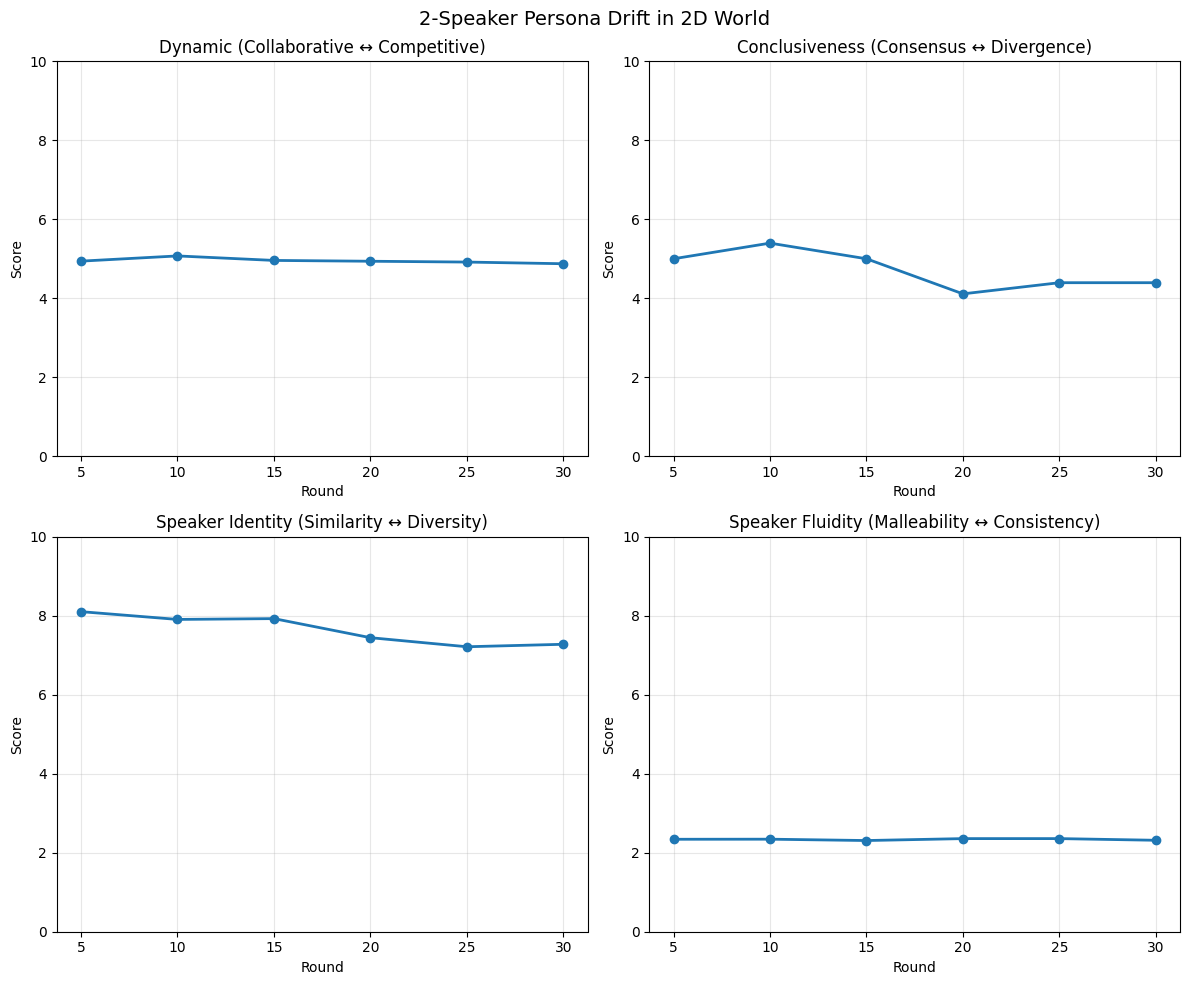

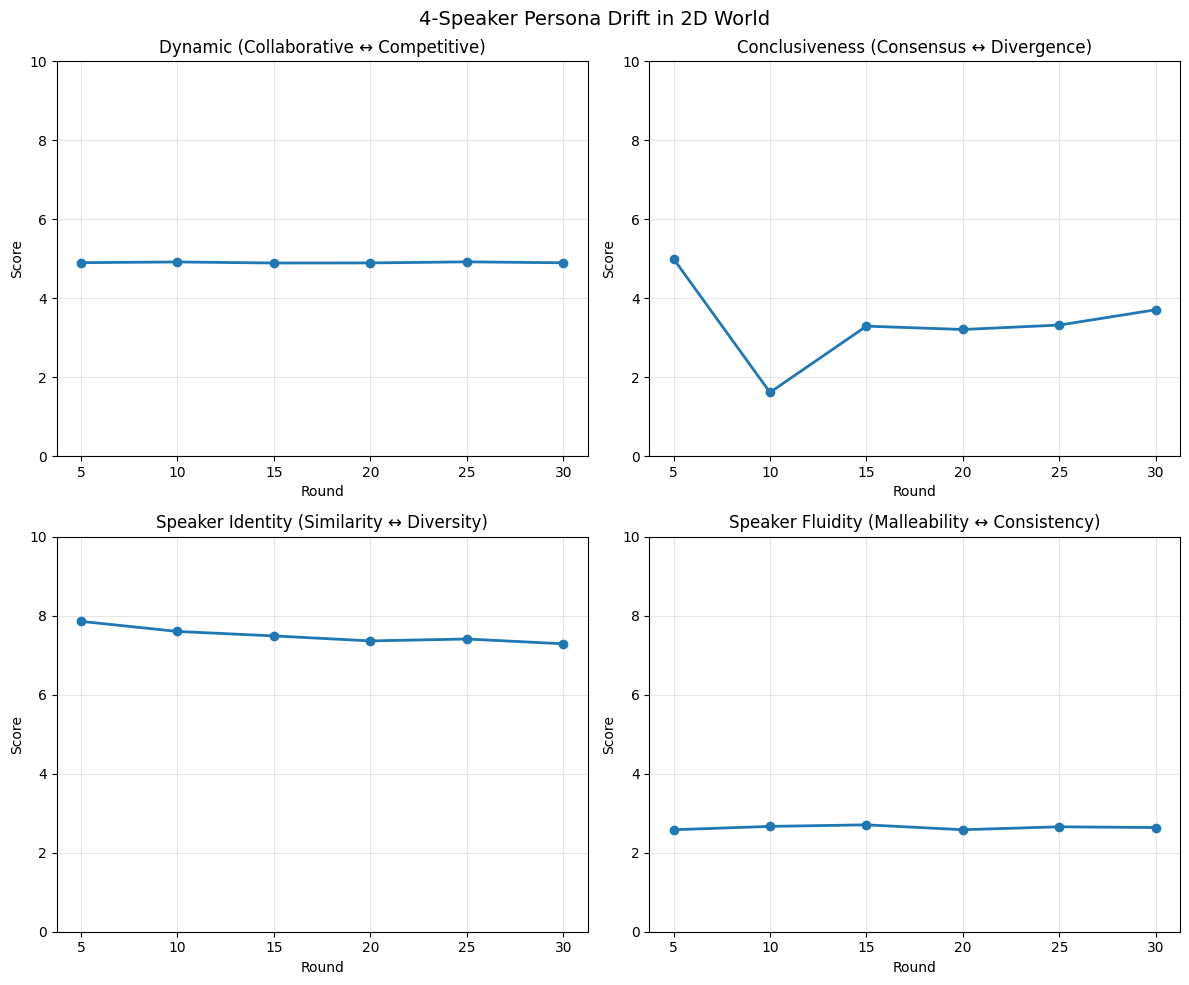

In [41]:
def plot_metric_drift(metric_history: List[Dict], title: str):
    """Plot metric changes over time."""
    rounds = [m["round"] for m in metric_history]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(title, fontsize=14)
    
    metrics_to_plot = [
        ("dynamic", "Dynamic (Collaborative ↔ Competitive)", axes[0, 0]),
        ("conclusiveness", "Conclusiveness (Consensus ↔ Divergence)", axes[0, 1]),
        ("speaker_identity", "Speaker Identity (Similarity ↔ Diversity)", axes[1, 0]),
        ("speaker_fluidity", "Speaker Fluidity (Malleability ↔ Consistency)", axes[1, 1])
    ]
    
    for metric_key, metric_label, ax in metrics_to_plot:
        values = [m[metric_key] for m in metric_history]
        ax.plot(rounds, values, marker='o', linewidth=2, markersize=6)
        ax.set_title(metric_label)
        ax.set_xlabel("Round")
        ax.set_ylabel("Score")
        ax.set_ylim(0, 10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot 2-speaker drift
plot_metric_drift(metrics_2d_2speaker, "2-Speaker Persona Drift in 2D World")

# Plot 4-speaker drift
plot_metric_drift(metrics_2d_4speaker, "4-Speaker Persona Drift in 2D World")


## Spatial Visualization

Let's visualize agent positions over time to see if spatial patterns emerge.


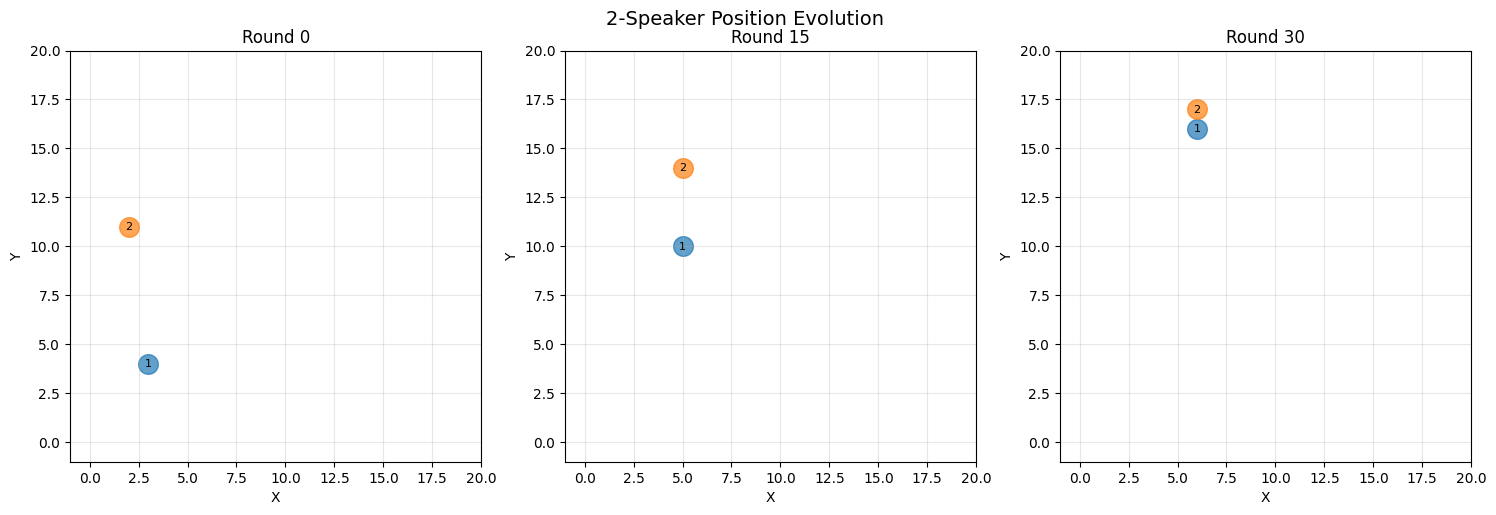

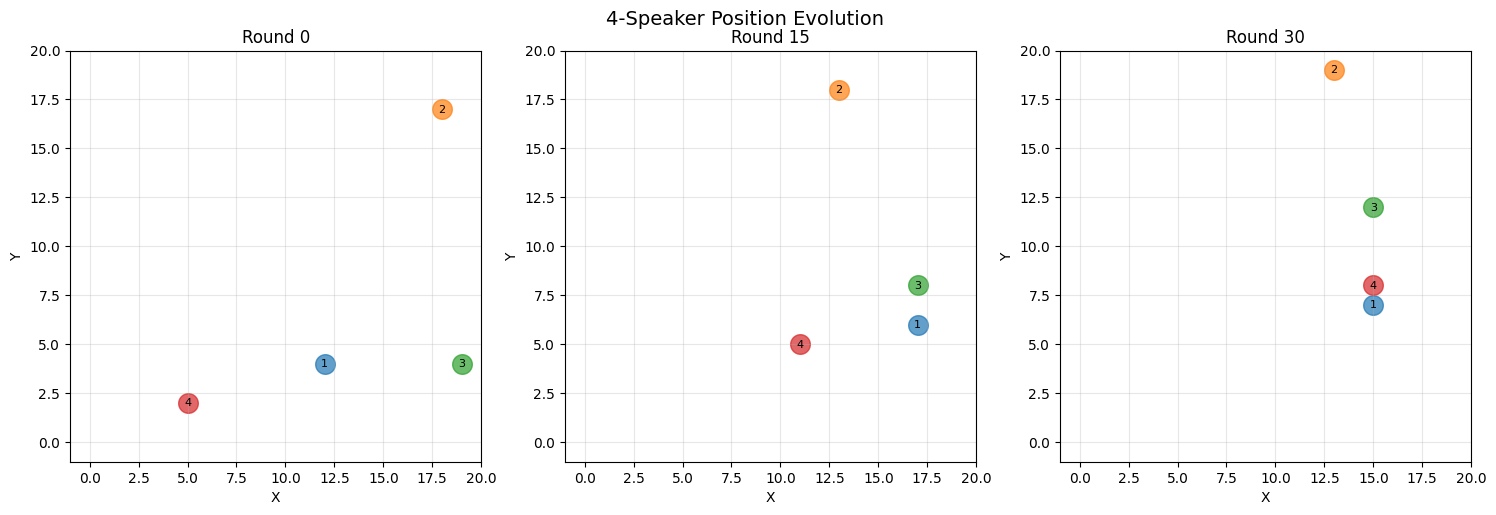

In [43]:
def plot_agent_positions(position_history: List[Dict], title: str):
    """Plot agent positions at different time points."""
    # Plot positions at start, middle, and end
    time_points = [0, len(position_history) // 2, len(position_history) - 1]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title, fontsize=14)
    
    for idx, time_point in enumerate(time_points):
        ax = axes[idx]
        positions = position_history[time_point]
        
        for agent_name, (x, y) in positions.items():
            ax.scatter(x, y, s=200, alpha=0.7, label=agent_name)
            ax.text(x, y, agent_name.split('_')[1], ha='center', va='center', fontsize=8)
        
        ax.set_xlim(-1, GRID_SIZE)
        ax.set_ylim(-1, GRID_SIZE)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_title(f"Round {time_point}")
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

# Plot 2-speaker positions
plot_agent_positions(positions_2d_2speaker, "2-Speaker Position Evolution")

# Plot 4-speaker positions
plot_agent_positions(positions_2d_4speaker, "4-Speaker Position Evolution")


## Comparison with Text-Only Results

### Key Observations

1. **Spatial Context Effects**: Does being in a 2D world affect persona stability?
2. **Proximity Influence**: Do agents near each other develop similar personas?
3. **Movement Patterns**: Do agents cluster or spread out?
4. **Metric Differences**: How do 2D world metrics compare to text-only (post 020)?

### 2D World vs Text-Only

**2D World (this post)**:
- Agents have spatial positions
- Proximity may influence communication
- Movement creates dynamic relationships
- Spatial context adds complexity

**Text-Only (post 020)**:
- No spatial constraints
- All agents "equally close"
- Pure conversational dynamics
- Simpler interaction model

## Summary

Persona drift in the 2D world shows:

- **Spatial patterns emerge**: Agents cluster
- **Metric stability**: Similar drift patterns to text-only, but with spatial variation
- **Group size matters**: 4 speakers show different dynamics than 2

The spatial context adds a new dimension to persona development:
- Agents can physically approach or avoid each other
- Spatial relationships may mirror conversational relationships
- Movement patterns may reflect persona characteristics

Future work could explore:
- How spatial proximity affects conversation topics
- Whether agents form spatial subgroups
- If movement patterns correlate with persona metrics
